In [102]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cv2
import skimage.io as skio
import skimage as sk
import heapq
from scipy.ndimage import distance_transform_edt as edt
from harris import get_harris_corners, dist2

# Part B.1

In [ ]:
def get_topk_points(h, coords, k, c=0.9):
    coords_transposed = coords.T
    nearest_higher = []
    dist_matrix = dist2(coords_transposed, coords_transposed)
    for coord_idx in range(len(coords_transposed)):
        nearest_distance = float('inf')
        curr_f = h[coords_transposed[coord_idx][0]][coords_transposed[coord_idx][1]]
        for coord_compare_idx in range(len(coords_transposed)):
            compare_f = h[coords_transposed[coord_compare_idx][0]][coords_transposed[coord_compare_idx][1]]
            if curr_f >= c * compare_f:
                continue
            nearest_distance = min(nearest_distance, dist_matrix[coord_idx][coord_compare_idx])
        nearest_higher.append(nearest_distance)
    
    top_k_indices = sorted(range(len(coords_transposed)), key=lambda idx: -nearest_higher[idx])
    if k > len(coords_transposed):
        print("Not enough harris corners.")
        k = len(coords_transposed)
    top_k_indices = top_k_indices[:k]
    
    indices = np.array(top_k_indices)
    return coords_transposed[indices]

Visualize the points

In [347]:
im = cv2.imread("data/A.1/set1/1.jpg", 0)
im_float = (im / 255).astype(np.float32)
im_float = cv2.resize(im_float, None, fx=0.3, fy=0.3)
im_colored = skio.imread("data/A.1/set1/1.jpg")
im_colored = (im_colored / 255).astype(np.float32)
im_colored = cv2.resize(im_colored, None, fx=0.3, fy=0.3)

In [348]:
h, coords = get_harris_corners(im_float)

In [ ]:
top_points = get_topk_points(h, coords, 200)

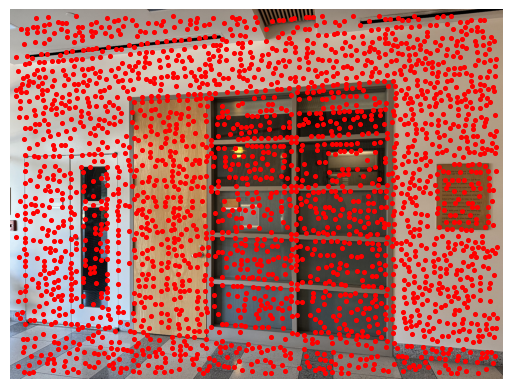

In [79]:
x, y = coords[0], coords[1]
plt.imshow(im_colored, origin='upper')
plt.scatter(y, x, s=7, facecolors='red')
plt.axis('off')
plt.savefig("data/B.1/total_points_colored.png", dpi=500)

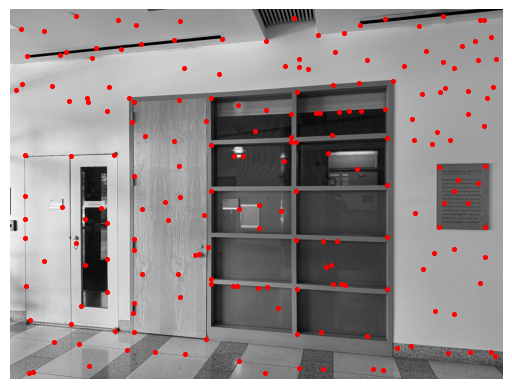

In [78]:
x, y = top_points.T[0], top_points.T[1]
plt.imshow(im_float, origin='upper', cmap='grey')
plt.scatter(y, x, s=7, facecolors='red')
plt.axis('off')
plt.savefig("data/B.1/ANMS_points_grey.png", dpi=500)

# Part B.2

In [42]:
def get_raw_patches(im, points):
    if points.shape[1] != 2:
        points = points.T
    patches = []
    for i in range(len(points)):
        x, y = points[i]
        curr_patch = []
        curr_patch_start_x = x - 17
        curr_patch_start_y = y - 17
        for row in range(8):
            curr_row = []
            for col in range(8):
                curr_row.append(im[curr_patch_start_x + 5 * row][curr_patch_start_y + 5 * col])
            curr_patch.append(curr_row)
        patches.append(np.array(curr_patch))
    return patches

def normalize_patches(patches, eps=1e-8):
    normalized_patches = []
    for patch in patches:
        mean = np.average(patch)
        patch_demeaned = patch - mean
        patch_normalized = patch_demeaned / (np.linalg.norm(patch_demeaned) + eps)
        normalized_patches.append(patch_normalized)
    return normalized_patches

Visualize an example harris corner's feature

In [43]:
patches = get_raw_patches(im_float, top_points)
normalized_patches = normalize_patches(patches)

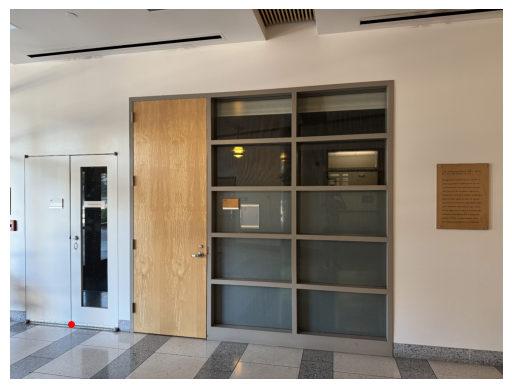

In [94]:
plt.imshow(im_colored, origin='upper')
plt.scatter(top_points[10][1], top_points[10][0], s=15, facecolors='red')
plt.axis('off')
plt.savefig("data/B.2/corner3/point_original_pos_colored.png", dpi=500)

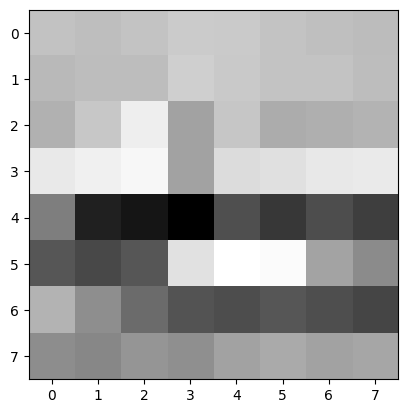

In [95]:
minimum, maximum = np.min(normalized_patches[10]), np.max(normalized_patches[10])
im_visualize = (normalized_patches[10] - minimum) / (maximum - minimum)
plt.imshow(im_visualize, cmap='grey')
skio.imsave("data/B.2/corner3/feature.jpg", (im_visualize * 255).astype(np.uint8))

# Part B.3

In [121]:
def get_good_matches(features1, features2, threshold=0.5):
    # Get features into format that can be fed into harris.dist2
    features1_length = len(features1)
    features1_vectorized = np.array(features1)
    features1_vectorized = features1_vectorized.reshape((features1_length, -1))
    features2_length = len(features2)
    features2_vectorized = np.array(features2)
    features2_vectorized = features2_vectorized.reshape((features2_length, -1))
    distances = dist2(features1_vectorized, features2_vectorized)
    print(distances.shape)
    res_matches = []
    for feature1_idx in range(features1_length):
        two_smallest = heapq.nsmallest(2, range(features2_length), key=lambda feature2_idx: distances[feature1_idx][feature2_idx])
        ratio = distances[feature1_idx][two_smallest[0]] / (distances[feature1_idx][two_smallest[1]] + 1e-8)
        #print(ratio)
        if ratio < threshold:
            res_matches.append((feature1_idx, two_smallest[0]))
    return res_matches

In [325]:
def visualize_point_correspondences(im1, im2, im1_pts, im2_pts):
    # utility function for visualizing point correspondences between two images.
    height, width = im1.shape[:2]

    pad_height, pad_width = int(height / 15), int(width / 15)

    big_im = np.full((height + pad_height * 2, width * 2 + pad_width * 3, 3), 1.0, dtype=np.float32)
    big_im[pad_height:pad_height + height, pad_width: pad_width + width] = im1
    big_im[pad_height:pad_height + height, pad_width * 2 + width: pad_width * 2 + width * 2] = im2
    print(big_im.shape)

    im1_pts = im1_pts + np.array([pad_height, pad_width])
    im2_pts = im2_pts + np.array([pad_height, 2 * pad_width + width])

    plt.figure(figsize=(20, 10))
    plt.imshow(big_im, origin='upper')
    ax = plt.gca()
    ax.set_title("Visualized Point Correspondences")
    ax.axis("off")

    for i in range(len(im1_pts)):
        y1, x1 = im1_pts[i]
        y2, x2 = im2_pts[i]
        plt.plot([x1, x2], [y1, y2], linewidth=1.5, alpha=0.9)
        plt.scatter([x1, x2], [y1, y2], s=15, facecolors='red')
    
    #plt.tight_layout()
    #plt.show()

Visualize results for a pair of images

In [125]:
im1 = cv2.imread("data/A.1/set1/1.jpg", 0)
im1_float = (im1 / 255).astype(np.float32)
im1_float = cv2.resize(im1_float, None, fx=0.3, fy=0.3)
im1_colored = skio.imread("data/A.1/set1/1.jpg")
im1_colored = (im1_colored / 255).astype(np.float32)
im1_colored = cv2.resize(im1_colored, None, fx=0.3, fy=0.3)

im2 = cv2.imread("data/A.1/set1/2.jpg", 0)
im2_float = (im2 / 255).astype(np.float32)
im2_float = cv2.resize(im2_float, None, fx=0.3, fy=0.3)
im2_colored = skio.imread("data/A.1/set1/2.jpg")
im2_colored = (im2_colored / 255).astype(np.float32)
im2_colored = cv2.resize(im2_colored, None, fx=0.3, fy=0.3)

In [128]:
h1, coords1 = get_harris_corners(im1_float)
top_points1 = get_topk_points(h1, coords1, 200)
patches1 = get_raw_patches(im1_float, top_points1)
normalized_patches1 = normalize_patches(patches1)

In [129]:
h2, coords2 = get_harris_corners(im2_float)
top_points2 = get_topk_points(h2, coords2, 200)
patches2 = get_raw_patches(im2_float, top_points2)
normalized_patches2 = normalize_patches(patches2)

In [122]:
correspondences = get_good_matches(normalized_patches1, normalized_patches2)

(200, 200)


In [271]:
im1_chosen_pt_idxs = np.array([correspondence[0] for correspondence in correspondences])
im2_chosen_pt_idxs = np.array([correspondence[1] for correspondence in correspondences])
lowe_pts_im1 = top_points1[im1_chosen_pt_idxs].astype(np.float32)
lowe_pts_im2 = top_points2[im2_chosen_pt_idxs].astype(np.float32)

(1455, 3770, 3)


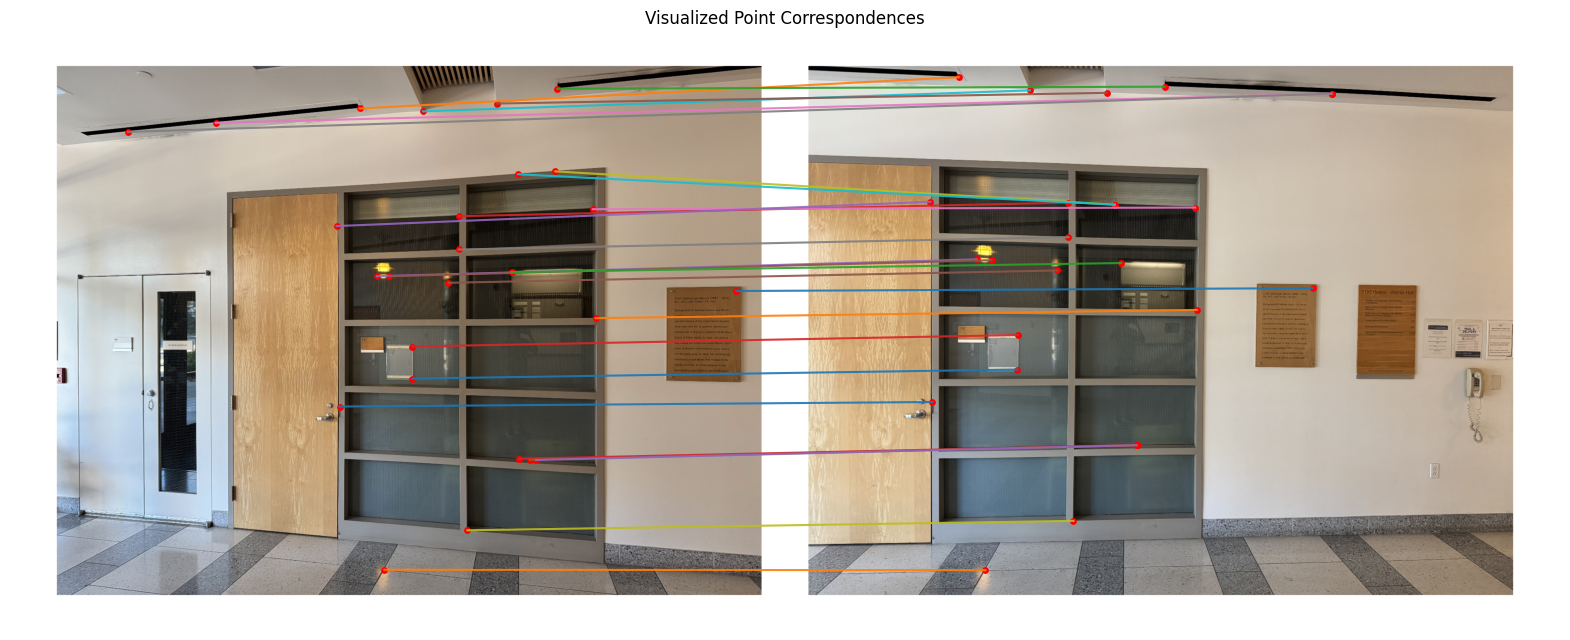

In [326]:
visualize_point_correspondences(im1_colored, im2_colored, lowe_pts_im1, lowe_pts_im2)

(np.float64(-0.5), np.float64(1713.5), np.float64(1284.5), np.float64(-0.5))

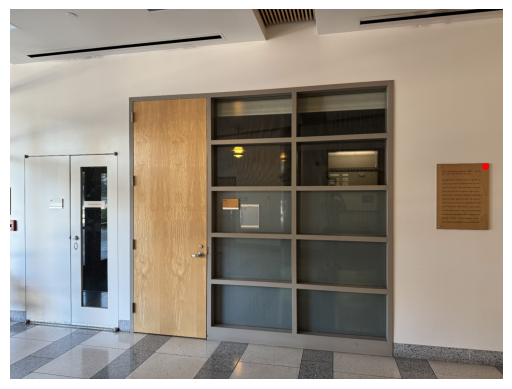

In [302]:
plt.imshow(im1_colored, origin='upper')
plt.scatter(lowe_pts_im1[0][1], lowe_pts_im1[0][0], s=15, facecolors='red')
plt.axis('off')

(np.float64(-0.5), np.float64(1713.5), np.float64(1284.5), np.float64(-0.5))

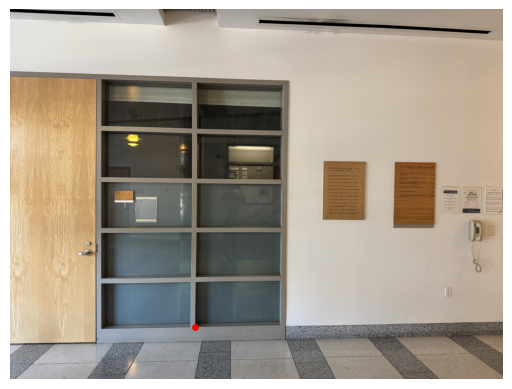

In [156]:
plt.imshow(im2_colored, origin='upper')
plt.scatter(top_points2[15][1], top_points2[15][0], s=15, facecolors='red')
plt.axis('off')

# Part B.4

First, some homography functions copied over from part 1.

In [327]:
def get_ls_inputs(im1_pts, im2_pts):
    if len(im1_pts) != len(im2_pts):
        print("point lists are of different lengths.")
        return
    A = []
    b = []
    for i in range(len(im1_pts)):
        x1, y1 = im1_pts[i]
        x2, y2 = im2_pts[i]
        A.append(np.array([x1, y1, 1, 0, 0, 0, -x1 * x2, -y1 * x2]))
        b.append(x2)
        A.append(np.array([0, 0, 0, x1, y1, 1, -x1 * y2, -y1 * y2]))
        b.append(y2)
    A = np.vstack(tuple(A))
    b = np.array(b)
    return A, b

def computeH(im1_pts, im2_pts):
    A, b = get_ls_inputs(im1_pts, im2_pts)
    h, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    return np.array([[h[0], h[1], h[2]],
                     [h[3], h[4], h[5]],
                     [h[6], h[7], 1]])

def homogeneous_to_2d(coords):
    x_coords = coords[0] / (coords[2] + 1e-8)
    y_coords = coords[1] / (coords[2] + 1e-8)
    return np.vstack((x_coords, y_coords))

In [341]:
def ransac(im1_pts, im2_pts, num_iters=200, eps=5.0):
    curr_best_set = np.array([])
    tot_num_pts = len(im1_pts)
    im1_pts, im2_pts = im1_pts.T, im2_pts.T
    im1_pts_homogeneous = np.vstack((im1_pts[0], im1_pts[1], np.ones(tot_num_pts)))
    #print(im1_pts_homogeneous.shape)
    for _ in range(num_iters):
        chosen_indices = np.random.choice(tot_num_pts, 4, replace=False)
        H = computeH(im1_pts.T[chosen_indices], im2_pts.T[chosen_indices])
        im2_res_homogeneous = H @ im1_pts_homogeneous
        im2_res = homogeneous_to_2d(im2_res_homogeneous)
        differences = im2_pts - im2_res
        differences_dist = np.linalg.norm(differences, axis=0)
        inliers_bools = differences_dist < eps
        if np.sum(inliers_bools) > np.sum(curr_best_set):
            curr_best_set = inliers_bools
    return im1_pts.T[curr_best_set], im2_pts.T[curr_best_set]

Test out previous example

In [342]:
im1_final_pts, im2_final_pts = ransac(lowe_pts_im1, lowe_pts_im2)

(1455, 3770, 3)


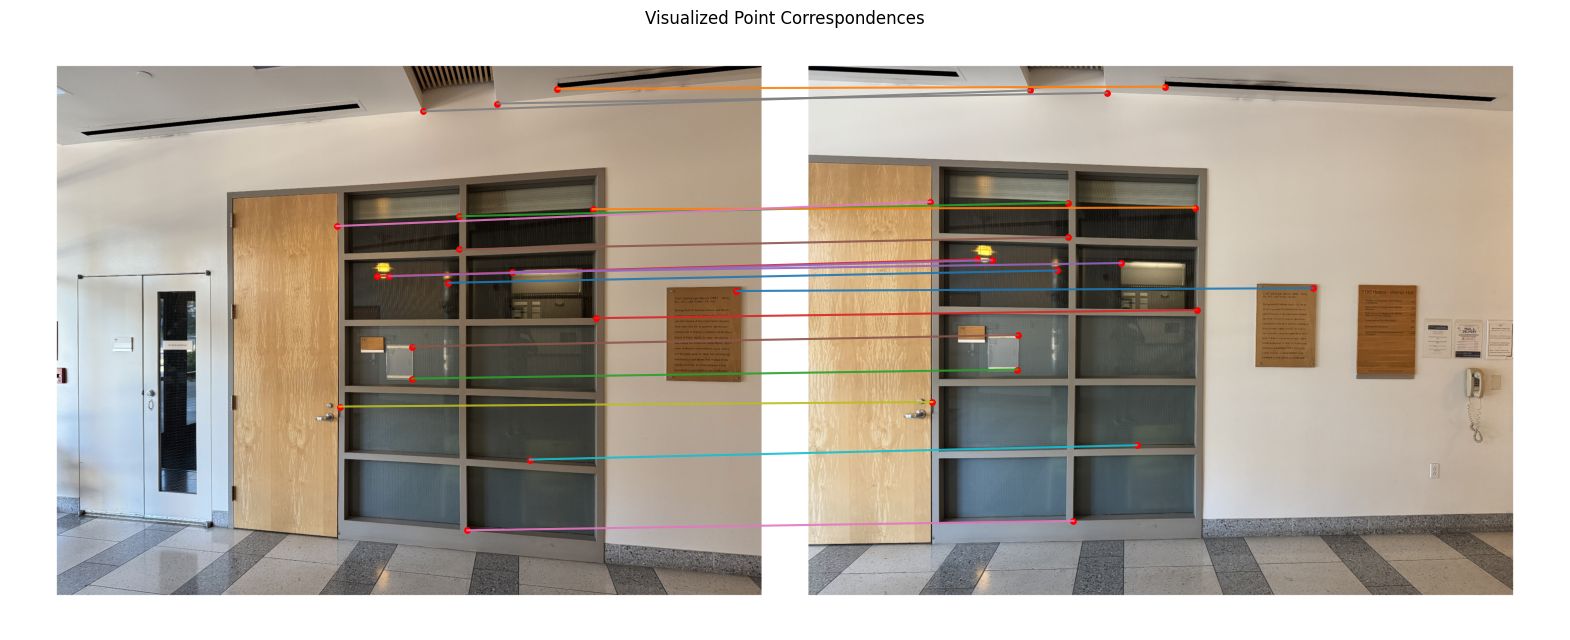

In [344]:
visualize_point_correspondences(im1_colored, im2_colored, im1_final_pts, im2_final_pts)

## Code for 3-image mosaics

In [359]:
def get_xy(homogenous_coords):
    return int(homogenous_coords[0] / homogenous_coords[2]), homogenous_coords[1] / homogenous_coords[2]
def get_xy_int(homogenous_coords):
    return int(homogenous_coords[0] / homogenous_coords[2]), int(homogenous_coords[1] / homogenous_coords[2])
def get_binary_mask(im, H):
    channel_height, channel_width = im.shape[:2]
    x1, y1 = get_xy_int(H @ np.array([0, 0, 1]))
    x2, y2 = get_xy_int(H @ np.array([channel_height, 0, 1]))
    x3, y3 = get_xy_int(H @ np.array([0, channel_width, 1]))
    x4, y4 = get_xy_int(H @ np.array([channel_height, channel_width, 1]))
    x_init = min(x1, x2, x3, x4)
    y_init = min(y1, y2, y3, y4)
    x_max = max(x1, x2, x3, x4)
    y_max = max(y1, y2, y3, y4)
    dx, dy = x_max - x_init, y_max - y_init
    res = [[0.0] * (dy + 1) for _ in range(dx + 1)]

    H_inv = np.linalg.inv(H)

    print(dx, dy)

    for x in range(dx + 1):
        for y in range(dy + 1):
            new_homogenous_coords = np.array([x_init + x, y_init + y, 1])
            original_homogenous_coords = H_inv @ new_homogenous_coords
            original_x, original_y = get_xy_int(original_homogenous_coords)
            if original_x < 0 or original_x >= channel_height:
                continue
            if original_y < 0 or original_y >= channel_width:
                continue
            res[x][y] = 1.0
    
    return np.array(res), x_init, y_init

In [360]:
def warp_image_one_channel_nn(channel, H):
    channel_height, channel_width = channel.shape
    x1, y1 = get_xy_int(H @ np.array([0, 0, 1]))
    x2, y2 = get_xy_int(H @ np.array([channel_height, 0, 1]))
    x3, y3 = get_xy_int(H @ np.array([0, channel_width, 1]))
    x4, y4 = get_xy_int(H @ np.array([channel_height, channel_width, 1]))
    x_init = min(x1, x2, x3, x4)
    y_init = min(y1, y2, y3, y4)
    x_max = max(x1, x2, x3, x4)
    y_max = max(y1, y2, y3, y4)
    dx, dy = x_max - x_init, y_max - y_init
    res = [[0.0] * (dy + 1) for _ in range(dx + 1)]

    H_inv = np.linalg.inv(H)

    print(dx, dy)

    for x in range(dx + 1):
        for y in range(dy + 1):
            new_homogenous_coords = np.array([x_init + x, y_init + y, 1])
            original_homogenous_coords = H_inv @ new_homogenous_coords
            original_x, original_y = get_xy_int(original_homogenous_coords)
            if original_x < 0 or original_x >= channel_height:
                continue
            if original_y < 0 or original_y >= channel_width:
                continue
            res[x][y] = channel[original_x][original_y]
    
    return np.array(res), x_init, y_init

def warp_image_helper_nn(im, H):
    res = []
    for channel_num in range(im.shape[-1]):
        channel_res, offset_x, offset_y = warp_image_one_channel_nn(im[:, :, channel_num], H)
        res.append(channel_res)
    res = np.dstack(tuple(res))
    return res, offset_x, offset_y

def warpImageNearestNeighbor(im, H):
    return warp_image_helper_nn(im, H)[0]

In [1129]:
im1 = cv2.imread("data/B.4/set1/1.jpg", 0)
im1_float = (im1 / 255).astype(np.float32)
im1_float = cv2.resize(im1_float, None, fx=0.3, fy=0.3)
im1_colored = skio.imread("data/B.4/set1/1.jpg")
im1_colored = (im1_colored / 255).astype(np.float32)
im1_colored = cv2.resize(im1_colored, None, fx=0.3, fy=0.3)

im2 = cv2.imread("data/B.4/set1/2.jpg", 0)
im2_float = (im2 / 255).astype(np.float32)
im2_float = cv2.resize(im2_float, None, fx=0.3, fy=0.3)
im2_colored = skio.imread("data/B.4/set1/2.jpg")
im2_colored = (im2_colored / 255).astype(np.float32)
im2_colored = cv2.resize(im2_colored, None, fx=0.3, fy=0.3)

im3 = cv2.imread("data/B.4/set1/3.jpg", 0)
im3_float = (im3 / 255).astype(np.float32)
im3_float = cv2.resize(im3_float, None, fx=0.3, fy=0.3)
im3_colored = skio.imread("data/B.4/set1/3.jpg")
im3_colored = (im3_colored / 255).astype(np.float32)
im3_colored = cv2.resize(im3_colored, None, fx=0.3, fy=0.3)

#### Put all three images on the same mosaic

Firstly, project im1 onto the pp of im2

In [1130]:
h1, coords1 = get_harris_corners(im1_float)
top_points1 = get_topk_points(h1, coords1, 500)
patches1 = get_raw_patches(im1_float, top_points1)
normalized_patches1 = normalize_patches(patches1)

In [1131]:
h2, coords2 = get_harris_corners(im2_float)
top_points2 = get_topk_points(h2, coords2, 500)
patches2 = get_raw_patches(im2_float, top_points2)
normalized_patches2 = normalize_patches(patches2)

In [1132]:
correspondences = get_good_matches(normalized_patches1, normalized_patches2, threshold=0.7)

(500, 500)


In [1133]:
im1_chosen_pt_idxs = np.array([correspondence[0] for correspondence in correspondences])
im2_chosen_pt_idxs = np.array([correspondence[1] for correspondence in correspondences])
lowe_pts_im1 = top_points1[im1_chosen_pt_idxs].astype(np.float32)
lowe_pts_im2 = top_points2[im2_chosen_pt_idxs].astype(np.float32)

In [1134]:
im1_final_pts, im2_final_pts = ransac(lowe_pts_im1, lowe_pts_im2, num_iters=400, eps=7)

In [1135]:
H12 = computeH(im1_final_pts, im2_final_pts)

In [1136]:
im1_projected, im1_dx, im1_dy = warp_image_helper_nn(im1_colored, H12)

1734 2009
1734 2009
1734 2009


/var/folders/zd/6l9_l17d02d4msw14wpqz0lw0000gn/T/ipykernel_58829/1848739466.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im1_projected)


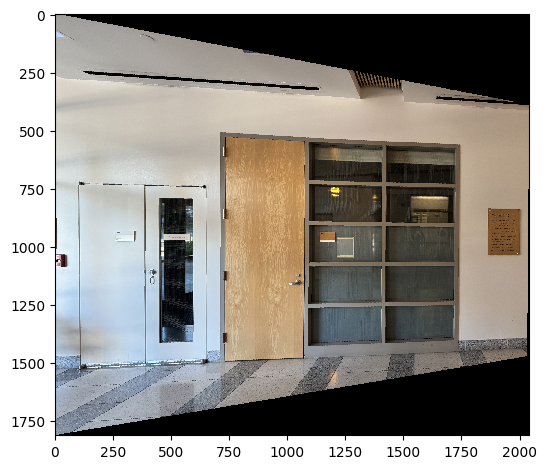

In [463]:
skio.imshow(im1_projected)

Secondly, project im3 onto the pp of im2

In [1137]:
h3, coords3 = get_harris_corners(im3_float)
top_points3 = get_topk_points(h3, coords3, 500)
patches3 = get_raw_patches(im3_float, top_points3)
normalized_patches3 = normalize_patches(patches3)

# corners and features for image 2 already gotten.

In [1138]:
correspondences = get_good_matches(normalized_patches3, normalized_patches2, threshold=0.7)

(500, 500)


In [1139]:
im3_chosen_pt_idxs = np.array([correspondence[0] for correspondence in correspondences])
im2_chosen_pt_idxs = np.array([correspondence[1] for correspondence in correspondences])
lowe_pts_im3 = top_points3[im3_chosen_pt_idxs].astype(np.float32)
lowe_pts_im2 = top_points2[im2_chosen_pt_idxs].astype(np.float32)

In [1140]:
im3_final_pts, im2_final_pts = ransac(lowe_pts_im3, lowe_pts_im2, num_iters=400, eps=7)

In [1141]:
H32 = computeH(im3_final_pts, im2_final_pts)

In [1142]:
im3_projected, im3_dx, im3_dy = warp_image_helper_nn(im3_colored, H32)

1829 2078
1829 2078
1829 2078


/var/folders/zd/6l9_l17d02d4msw14wpqz0lw0000gn/T/ipykernel_58829/358993683.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im3_projected)


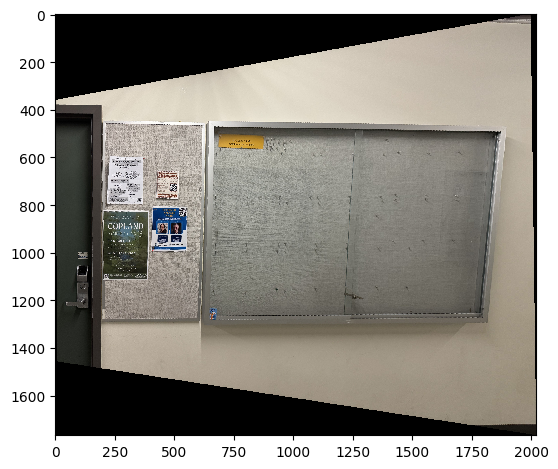

In [592]:
skio.imshow(im3_projected)

Now, put all images on the same mosaic (mosaic with same size), as well as their respective masks

In [1143]:
im1_x0, im1_y0 = im1_dx, im1_dy
im1_x1, im1_y1 = im1_dx + im1_projected.shape[0], im1_dy + im1_projected.shape[1]

im2_x0, im2_y0 = 0, 0
im2_x1, im2_y1 = im2_float.shape[0], im2_float.shape[1]

im3_x0, im3_y0 = im3_dx, im3_dy
im3_x1, im3_y1 = im3_dx + im3_projected.shape[0], im3_dy + im3_projected.shape[1]

In [1144]:
overall_x_init = min(im1_x0, im2_x0, im3_x0)
overall_x_end = max(im1_x1, im2_x1, im3_x1)
overall_y_init = min(im1_y0, im2_y0, im3_y0)
overall_y_end = max(im1_y1, im2_y1, im3_y1)
width, height = overall_y_end - overall_y_init, overall_x_end - overall_x_init

In [1145]:
image1_mask_small, _, _ = get_binary_mask(im1_float, H12)
res_image1 = [[np.array([0.0, 0.0, 0.0]) for _ in range(width)] for _ in range(height)]
mask_image1 = [[0.0 for _ in range(width)] for _ in range(height)]
for row in range(im1_projected.shape[0]):
    for col in range(im1_projected.shape[1]):
        im1_row, im1_col = row + im1_x0, col + im1_y0
        mosaic_row, mosaic_col = im1_row - overall_x_init, im1_col - overall_y_init
        res_image1[mosaic_row][mosaic_col] = im1_projected[row][col]
        mask_image1[mosaic_row][mosaic_col] = image1_mask_small[row][col]
res_image1 = np.array(res_image1)
mask_image1 = np.array(mask_image1)
skio.imsave("data/B.4/set1/trials/1_trial.jpg", (res_image1 * 255).astype(np.uint8))

1734 2009


In [1146]:
res_image2 = [[np.array([0.0, 0.0, 0.0]) for _ in range(width)] for _ in range(height)]
mask_image2 = [[0.0 for _ in range(width)] for _ in range(height)]
for row in range(im2_colored.shape[0]):
    for col in range(im2_colored.shape[1]):
        im2_row, im2_col = row + im2_x0, col + im2_y0
        mosaic_row, mosaic_col = im2_row - overall_x_init, im2_col - overall_y_init
        res_image2[mosaic_row][mosaic_col] = im2_colored[row][col]
        mask_image2[mosaic_row][mosaic_col] = 1.0
res_image2 = np.array(res_image2)
mask_image2 = np.array(mask_image2)
skio.imsave("data/B.4/set1/trials/2_trial.jpg", (res_image2 * 255).astype(np.uint8))

In [1147]:
image3_mask_small, _, _ = get_binary_mask(im3_float, H32)
res_image3 = [[np.array([0.0, 0.0, 0.0]) for _ in range(width)] for _ in range(height)]
mask_image3 = [[0.0 for _ in range(width)] for _ in range(height)]
for row in range(im3_projected.shape[0]):
    for col in range(im3_projected.shape[1]):
        im3_row, im3_col = row + im3_x0, col + im3_y0
        mosaic_row, mosaic_col = im3_row - overall_x_init, im3_col - overall_y_init
        res_image3[mosaic_row][mosaic_col] = im3_projected[row][col]
        mask_image3[mosaic_row][mosaic_col] = image3_mask_small[row][col]
res_image3 = np.array(res_image3)
mask_image3 = np.array(mask_image3)
skio.imsave("data/B.4/set1/trials/3_trial.jpg", (res_image3 * 255).astype(np.uint8))

1829 2078


Blend image1 with image2

In [1148]:
d1 = edt(mask_image1)
d2 = edt(mask_image2)

In [1149]:
w = d1 / (d1 + d2 + 1e-8)
w = np.clip(w, 0, 1)

In [1150]:
w_reshaped = w.reshape(w.shape[0], w.shape[1], 1)

In [1151]:
res12 = res_image1 * w_reshaped + res_image2 * (1 - w_reshaped)

In [ ]:
skio.imshow(res12)

/var/folders/zd/6l9_l17d02d4msw14wpqz0lw0000gn/T/ipykernel_94024/3063671951.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(res12)


Blend image12 with image3

In [1152]:
d12 = edt(mask_image1 + mask_image2)
d3 = edt(mask_image3)

In [1153]:
w = d12 / (d12 + d3 + 1e-8)
w = np.clip(w, 0, 1)

In [1154]:
w_reshaped = w.reshape(w.shape[0], w.shape[1], 1)

In [1155]:
res123 = res12 * w_reshaped + res_image3 * (1 - w_reshaped)

In [ ]:
skio.imshow(res123)

/var/folders/zd/6l9_l17d02d4msw14wpqz0lw0000gn/T/ipykernel_94024/346618293.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(res123)


In [1156]:
skio.imsave("data/B.4/set1/res.jpg", (res123 * 255).astype(np.uint8))

(1455, 3770, 3)


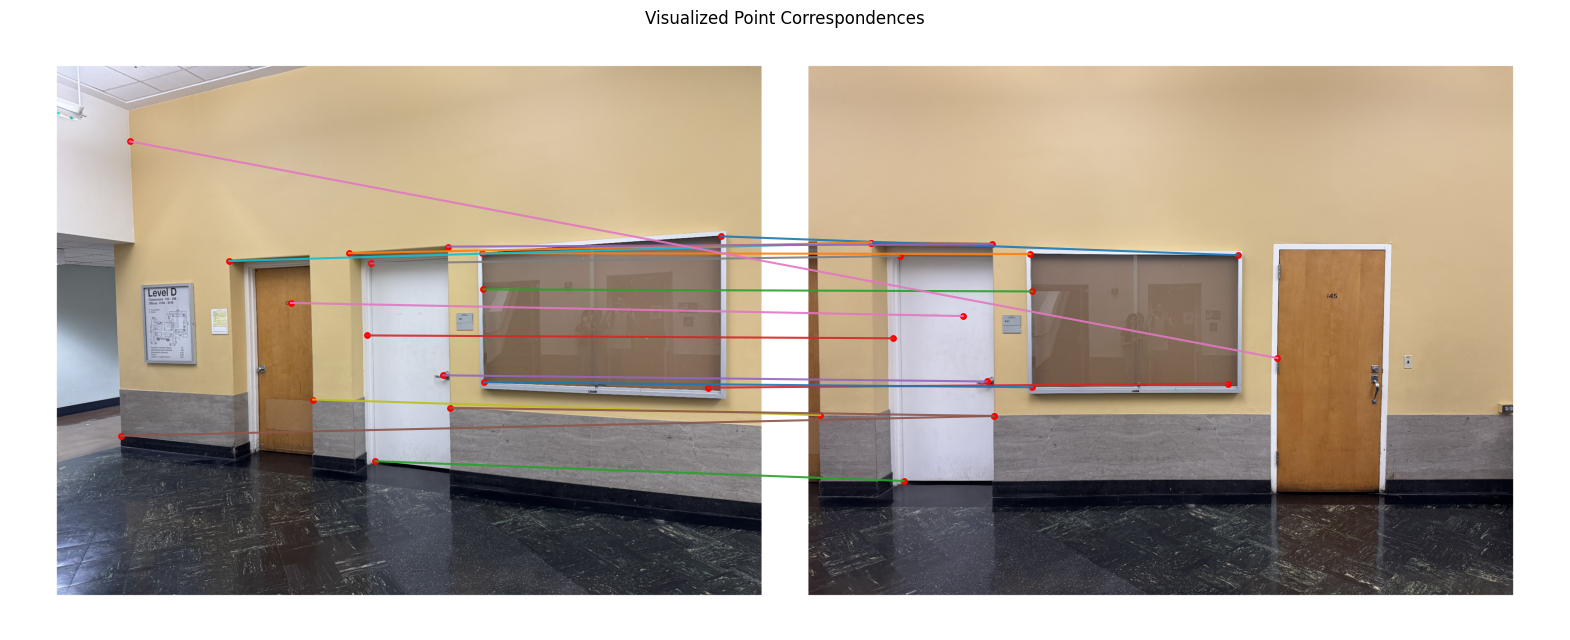

In [1071]:
visualize_point_correspondences(im1_colored, im2_colored, lowe_pts_im1, lowe_pts_im2)